In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import binary_dilation
from skimage.segmentation import find_boundaries
from skimage.measure import label, regionprops
from skimage import exposure
from czifile import imread
import torch
from huggingface_hub import hf_hub_download
from skimage.io import imsave
from cellpose import models 
model_cellpose = models.Cellpose(model_type='cyto')
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [12]:
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image(image, title, path):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{title} {path}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def count(mask): 
    """Count the number of unique labels in the mask."""
    return len(np.unique(label(mask))) - 1  # Exclude background label (0)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1], image[2]

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model_cellpose.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def find_swiss_cheese_inclusions(inclusion_image, red_channel_thresholded, verbose=False):

    """
    Identify and categorize inclusion objects based on their overlap with lipid droplets.
    - Labels individual inclusion objects in the binary inclusion image.
    - For each inclusion:
        - Checks whether it overlaps with the thresholded red channel (e.g., lipid droplets).
        - If it overlaps, adds it to the "swiss cheese" mask (inclusions with holes).
        - Otherwise, adds it to the "regular inclusion" mask (solid inclusions).
    - Returns two binary masks:
        - swiss_chess_inclusions: inclusions that intersect with the red channel
        - regular_inclusions: inclusions that do not intersect with the red channel
    """
    swiss_chess_inclusions = np.zeros_like(inclusion_image)
    regular_inclusions = np.zeros_like(inclusion_image)
    labeled_inclusions = label(inclusion_image)
    for i, inclusion in enumerate(regionprops(labeled_inclusions)):
        mask = labeled_inclusions == inclusion.label
        overlap = mask * red_channel_thresholded
        if np.sum(overlap) > 30:
            swiss_chess_inclusions += mask
        else:
            regular_inclusions += mask
    return swiss_chess_inclusions, regular_inclusions


def remove_overlapping_objects(mask1, mask2):

    # Label mask1 if it's not already labeled
    labeled_mask1 = label(mask1)
    result_mask = np.zeros_like(mask1, dtype=np.uint8)

    for region in regionprops(labeled_mask1):
        obj_mask = (labeled_mask1 == region.label)

        # Check if it overlaps with mask2
        if np.any(obj_mask & (mask2 > 0)):
            continue  # Skip overlapping object
        else:
            result_mask[obj_mask] = 1  # Keep the non-overlapping object

    return result_mask

def extract_touching_objects(mask1, mask2):
    """
    Return a mask containing whole objects in mask1
    that touch mask2.
    """
    touching_objects = np.zeros_like(mask1, dtype=np.uint8)

    labeled_mask = label(mask1)

    for region in regionprops(labeled_mask):
        region_mask = (labeled_mask == region.label)
        overlap = region_mask * mask2

        if np.sum(overlap) > 0:
            touching_objects += region_mask

    return touching_objects

def count_touching_objects(mask1, mask2):
    """
    Count how many objects in mask1 touch any part of mask2.

    Parameters:
        mask1 (ndarray): Binary or labeled mask (objects to test).
        mask2 (ndarray): Binary mask (objects to touch against).

    Returns:
        int: Number of objects in mask1 that touch mask2.
    """
    # Ensure binary input
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    labeled_mask1 = label(mask1)
    count = 0

    for region in regionprops(labeled_mask1):
        obj_mask = labeled_mask1 == region.label
        if np.any(obj_mask & mask2):
            count += 1

    return count

In [14]:
@torch.no_grad()
def analysis(green: np.ndarray, red:np.ndarray, yellow:np.ndarray, path:str, predictor, segmenter) -> pd.DataFrame:

    data = []
    df_cell_summary = pd.DataFrame()

    print("Starting analysis...")
    #preprocess green channel


    green_thresholded = automatic_instance_segmentation(
         predictor=predictor,
         segmenter=segmenter,
         input_path=green,
         ndim=2,
    ) > 0

    labeled_cells = segment_cells(yellow)


    #contrast_adjusted_green_normalized = (green - green.min()) / (green.max() - green.min())
    #threshold_value_green = np.mean(contrast_adjusted_green_normalized) + (np.std(contrast_adjusted_green_normalized) * 4.5)
    #green_thresholded = contrast_adjusted_green_normalized > threshold_value_green
    #green_thresholded = remove_small_objects(green_thresholded, min_size=10)
    #display_two_images(green, green_ml, "Green Channel", "Green ML", path)
    display_two_images(green, green_thresholded, "Green Channel", "Green Thresholded", path)

    #segment red channel to find lipid droplets
    contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
    threshold_value_red = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 4)
    red_thresholded = contrast_adjusted_red_normalized > threshold_value_red
    red_thresholded = remove_small_objects(red_thresholded, min_size=10)
    #remove the orange and inclusion overlap
    display_two_images(red, red_thresholded, "Red Channel", "Red Thresholded", path)

    display_two_images(yellow, labeled_cells, "Yellow Channel", "Labeled Cells", path)
    cell_count = 1

    for i, cell in enumerate(regionprops(labeled_cells)): #loop through each cell in the labeled cells
        if cell.area < 100:  # Skip tiny regions likely to be noise
            continue

        # Create a mask for the current cell
        mask = labeled_cells == cell.label

        green_in_cell = extract_touching_objects(green_thresholded, mask)
        yellow_in_cell = yellow * mask
        yellow_MFI = (np.sum(yellow_in_cell) / np.sum(mask)) if np.sum(mask) > 0 else 0
        pixel_count = np.count_nonzero(green * mask)

        green_MFI = (np.sum(green * mask) / pixel_count) if pixel_count > 0 else 0
        #display_two_images(mask, yellow_in_cell, "yellow mask", "Yellow in Cell", path)


        data.append({
            'Image Path': path,
            'Cell Number': cell_count,
            "Cell Area": cell.area,
            "Number of green objects": count(green_in_cell),
            "MFI of yellow": yellow_MFI,
            "MFI of green": green_MFI,
            "MFI of green / MFI of yellow": (green_MFI / yellow_MFI) if yellow_MFI > 0 else 0,
            "Green structures / MFI of yellow": (count(green_in_cell) / yellow_MFI) if yellow_MFI > 0 else 0,
            "Number of lipophagy events": count_touching_objects(green_in_cell, red_thresholded)
        })
        cell_count += 1
    df_cell_summary = pd.DataFrame(data)
    return df_cell_summary
    

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:261: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/images_uint8, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:274: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/masks, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)


Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


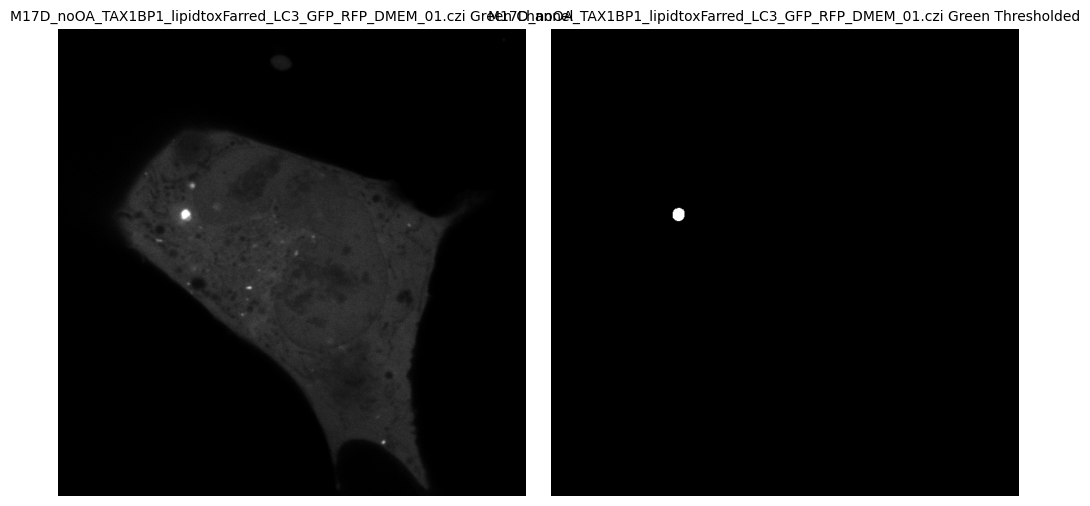

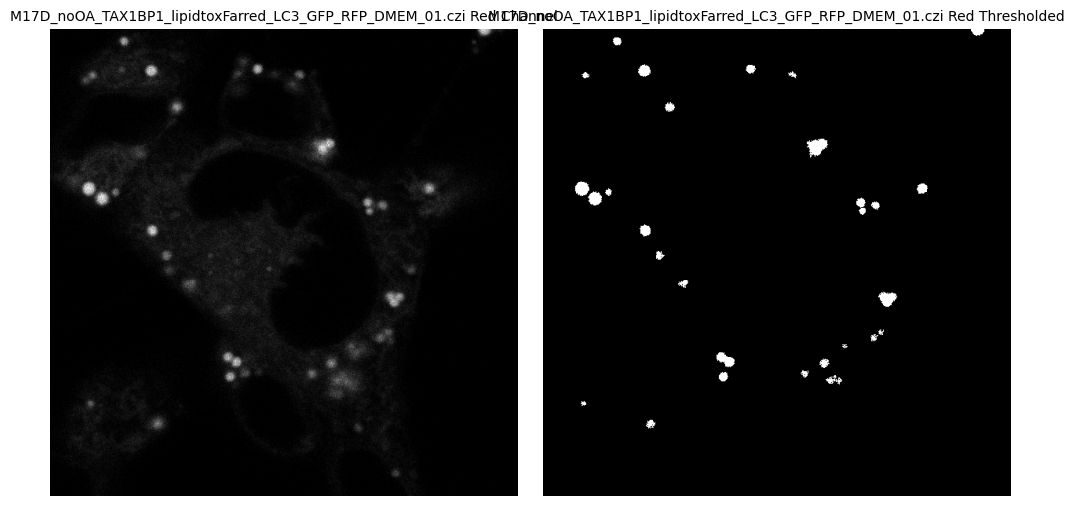

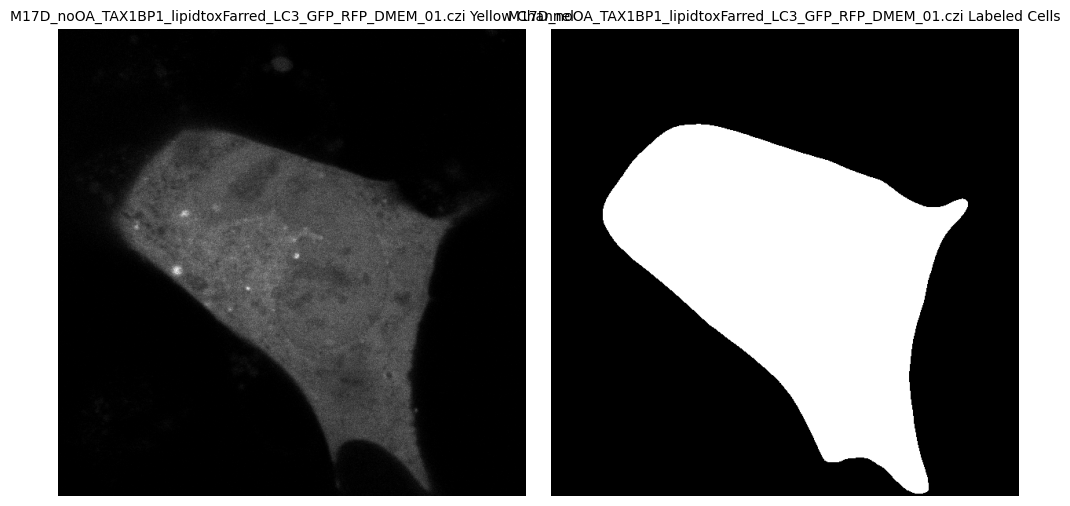

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


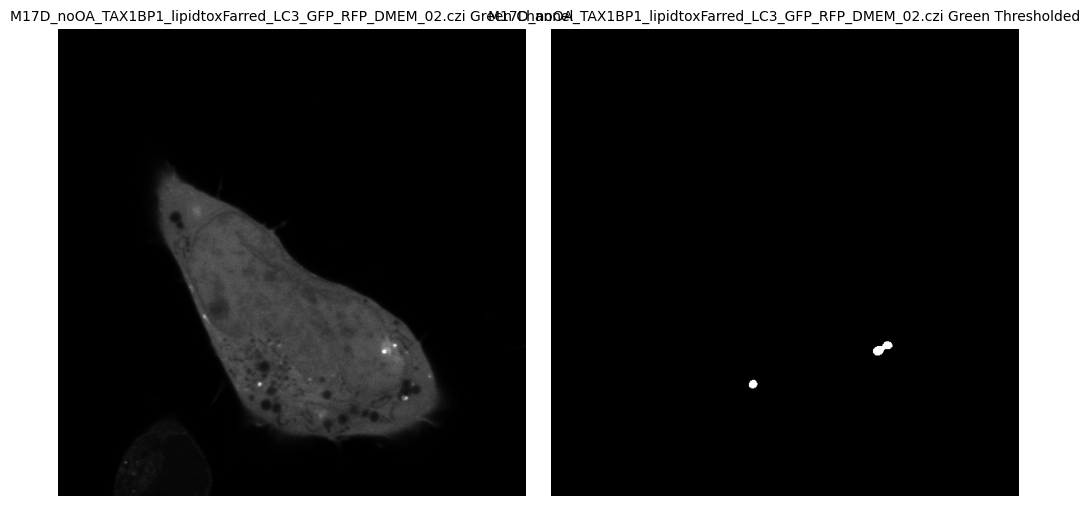

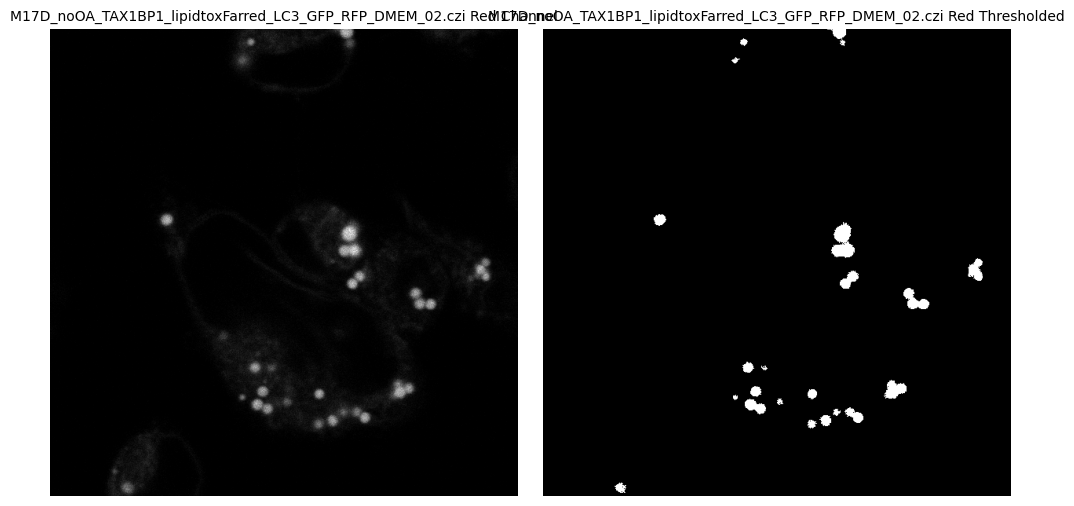

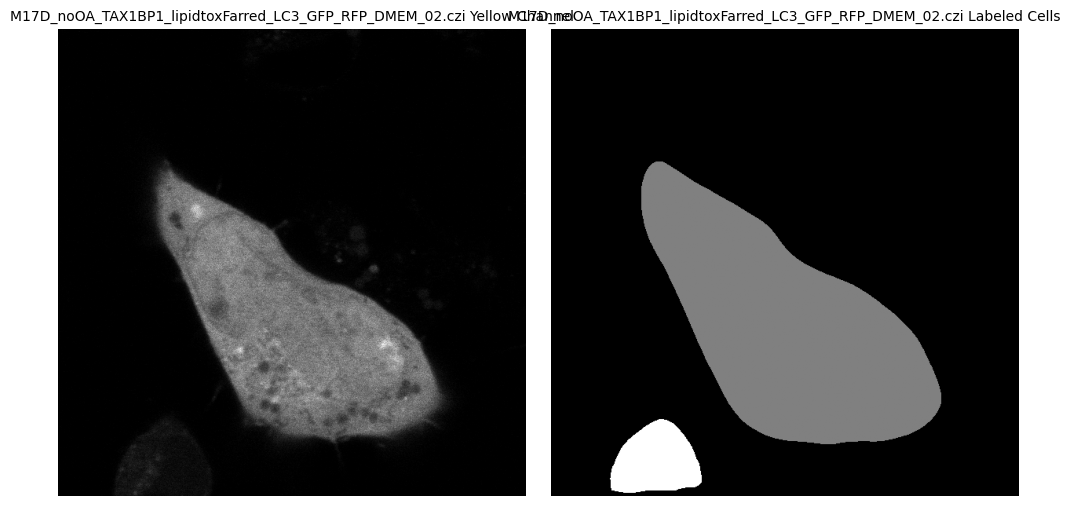

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


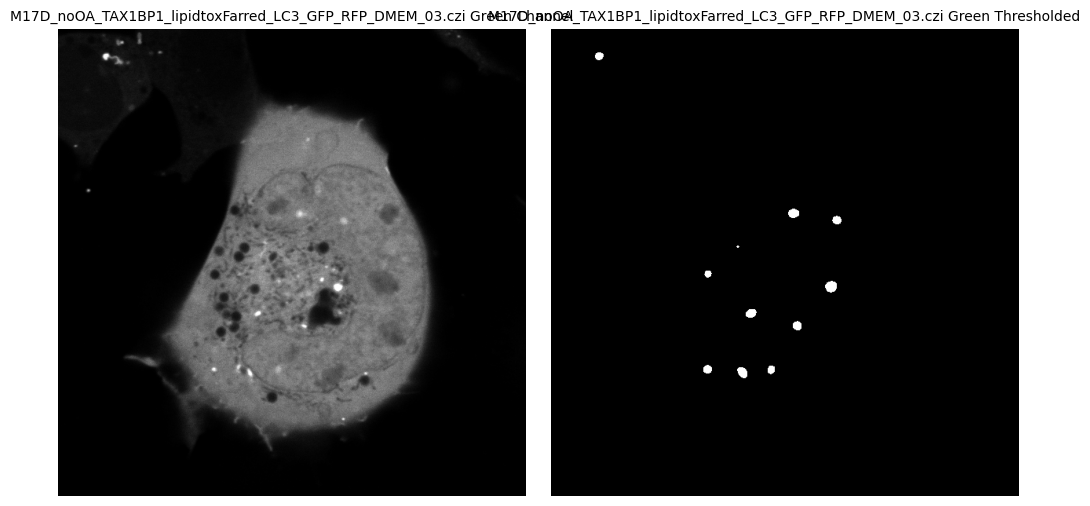

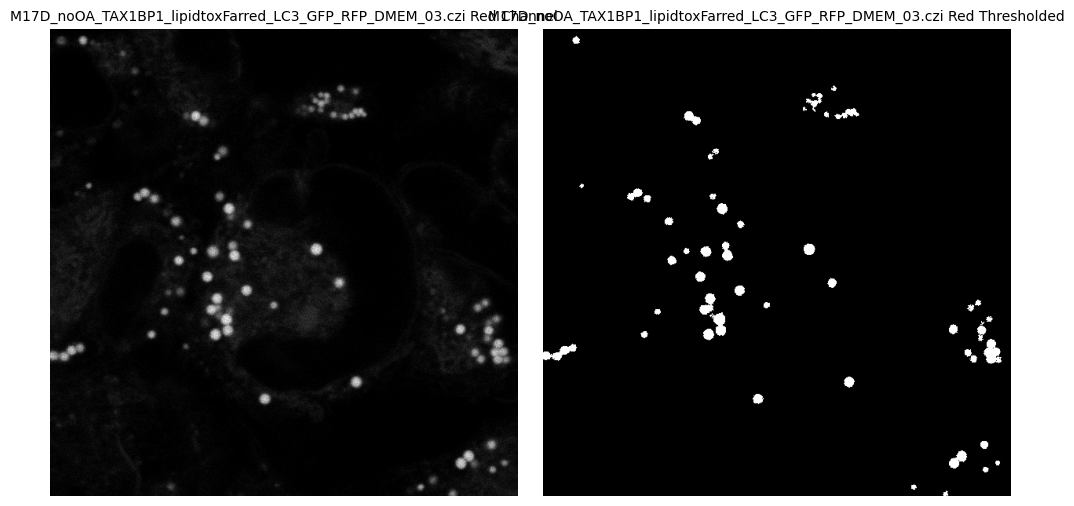

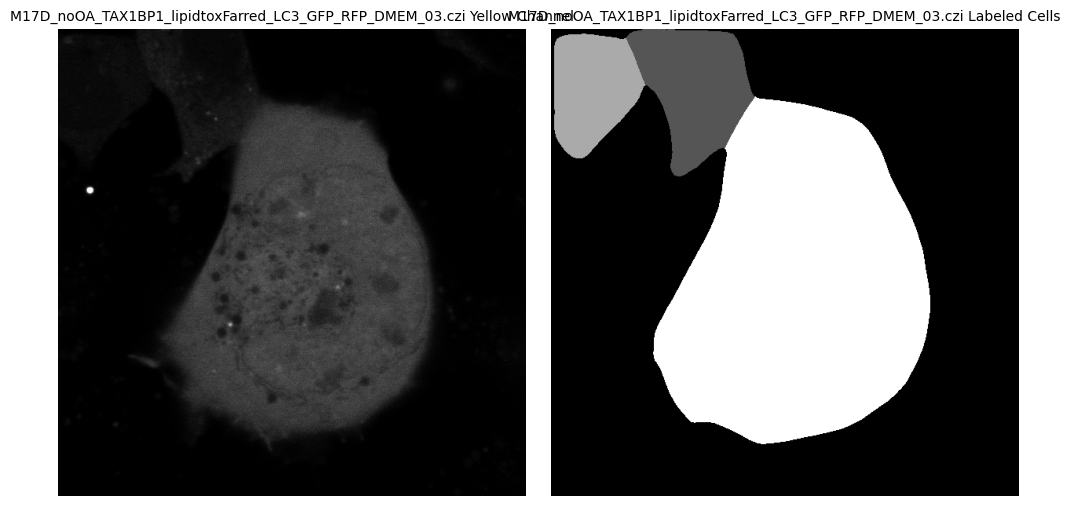

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


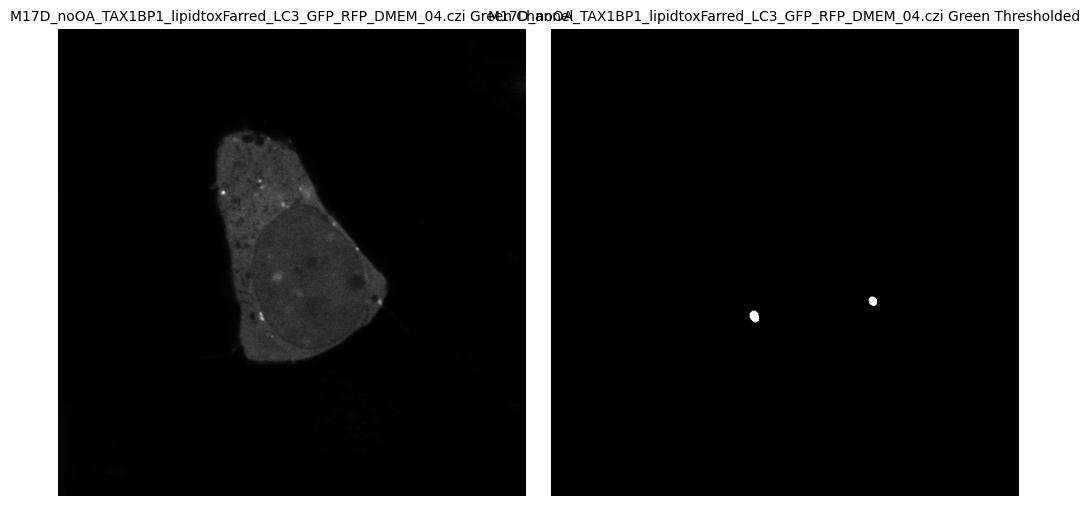

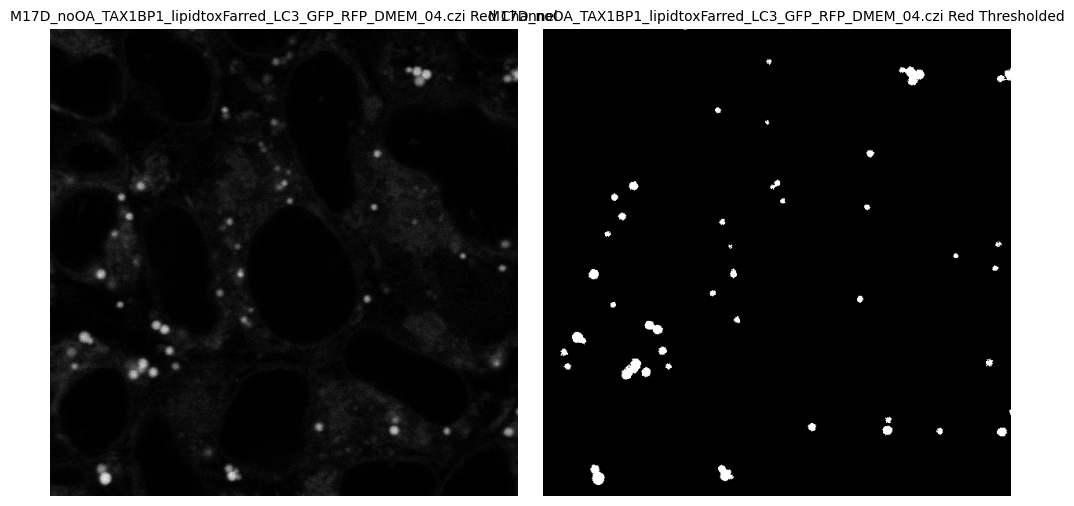

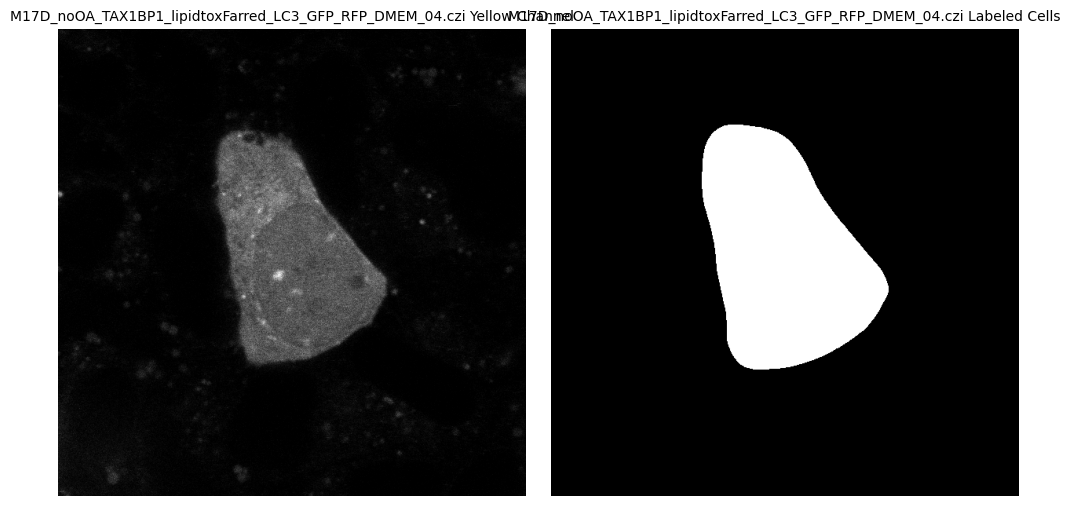

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


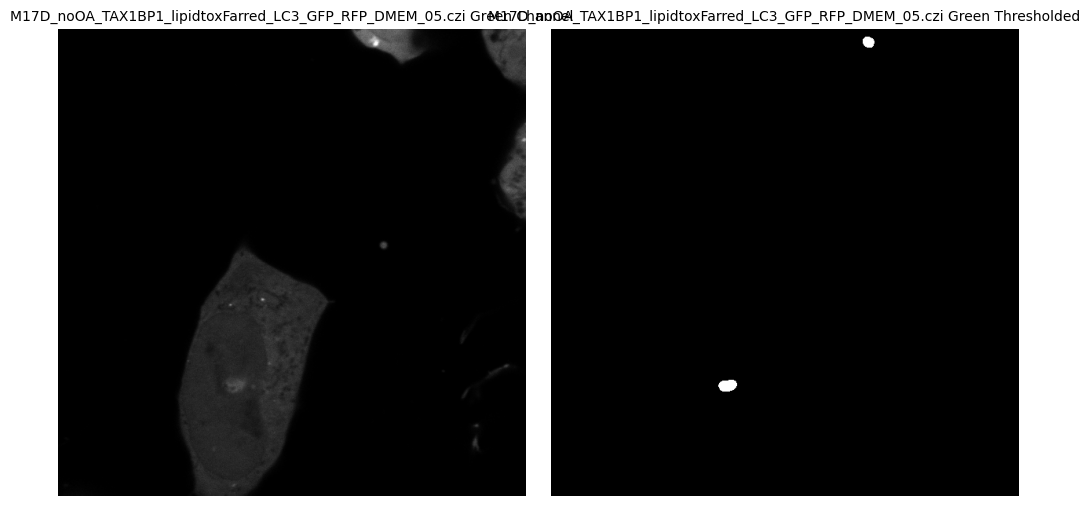

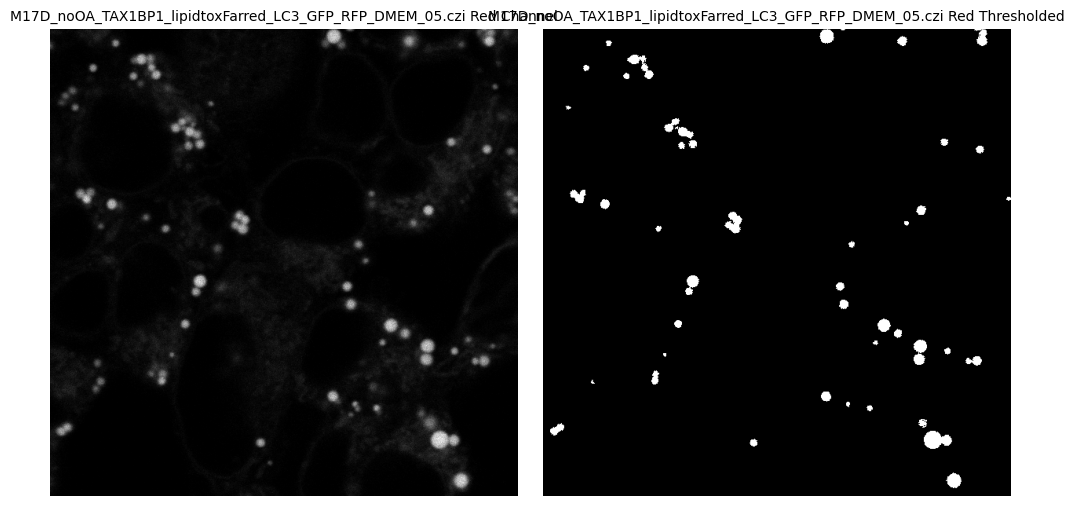

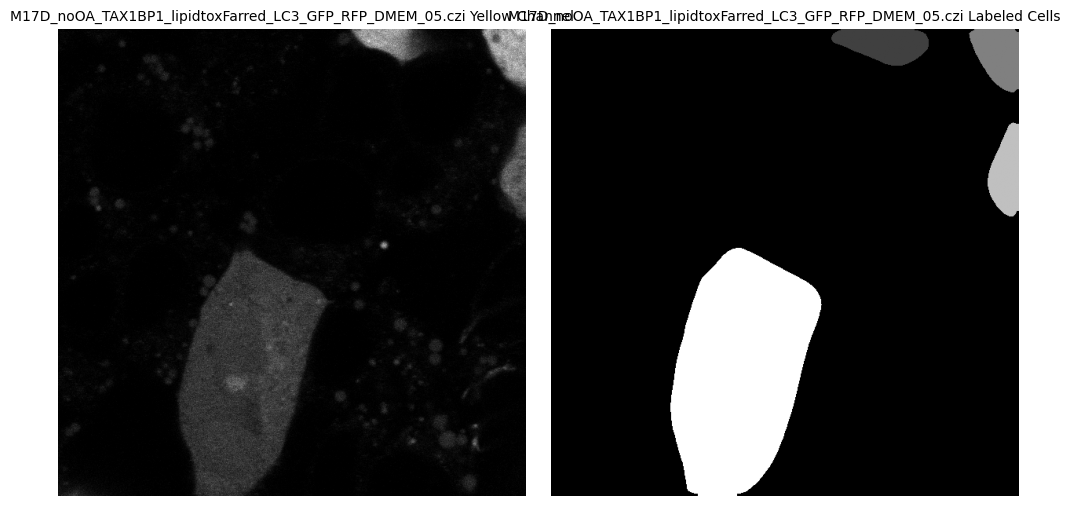

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


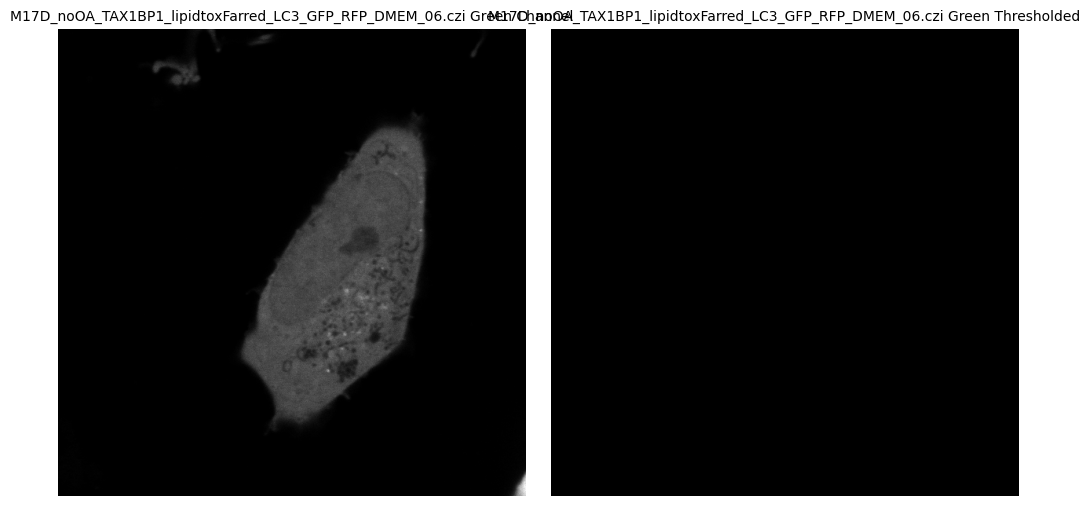

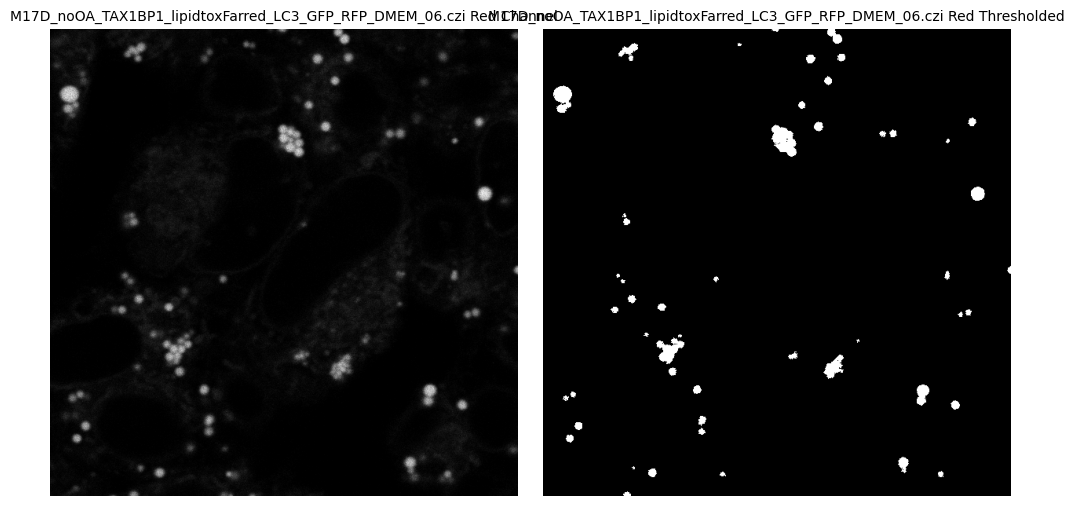

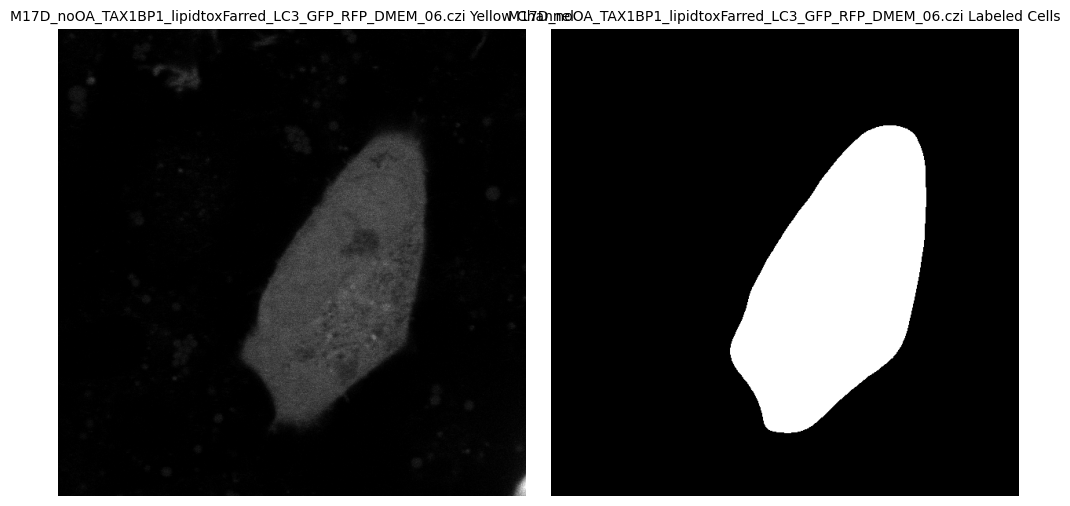

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


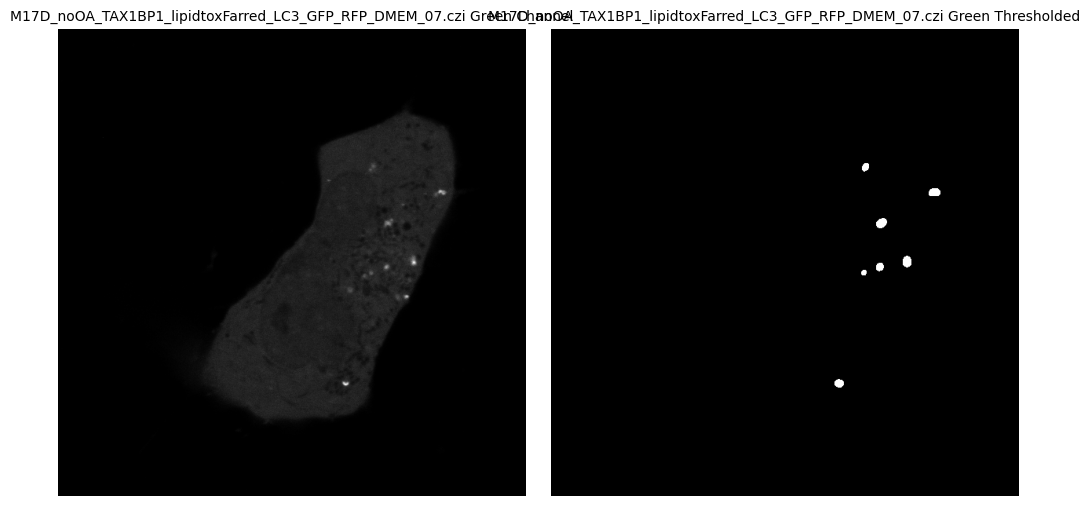

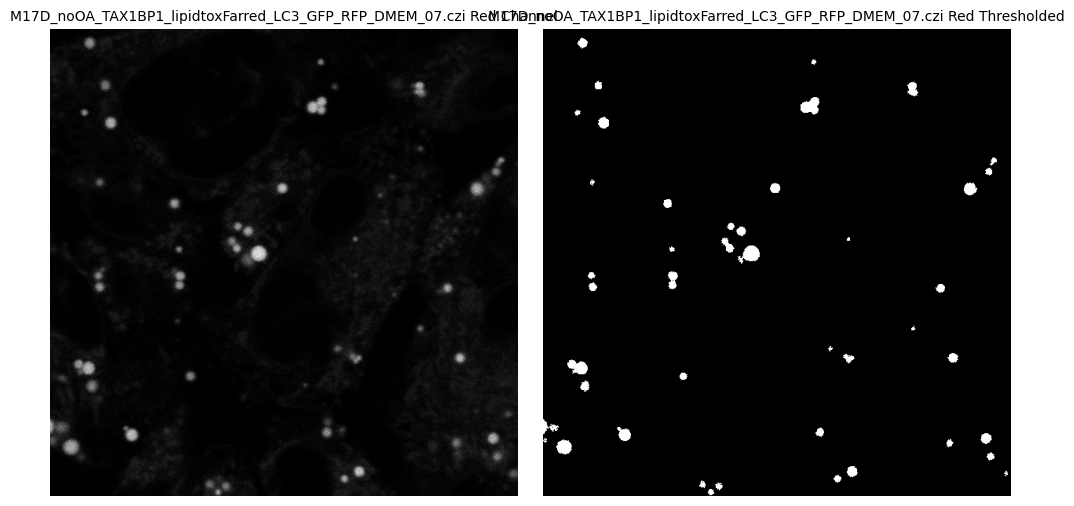

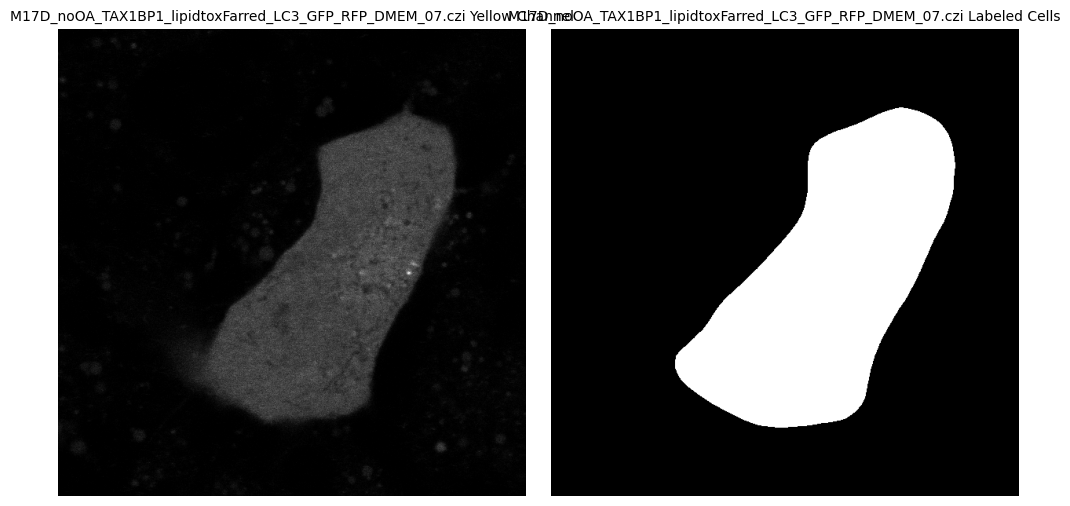

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


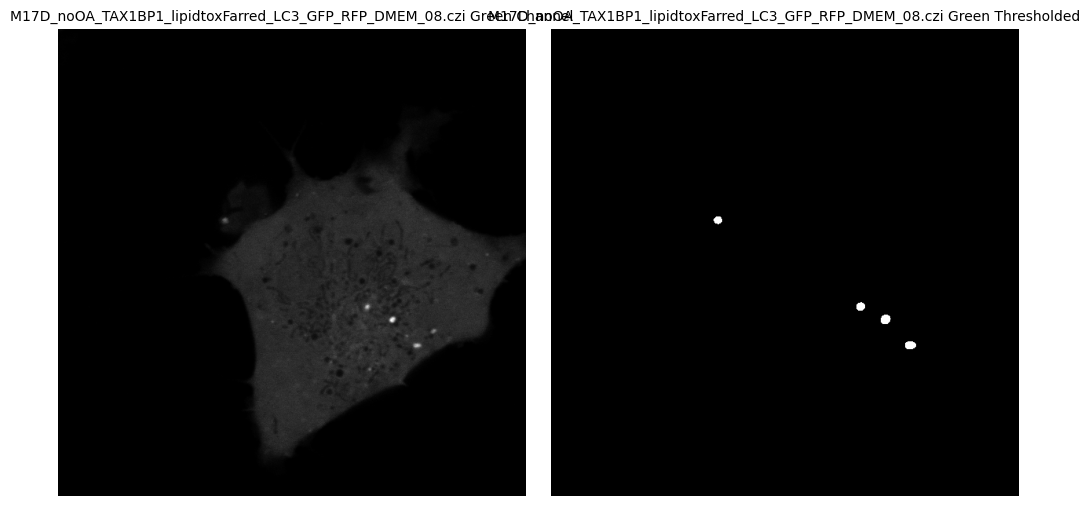

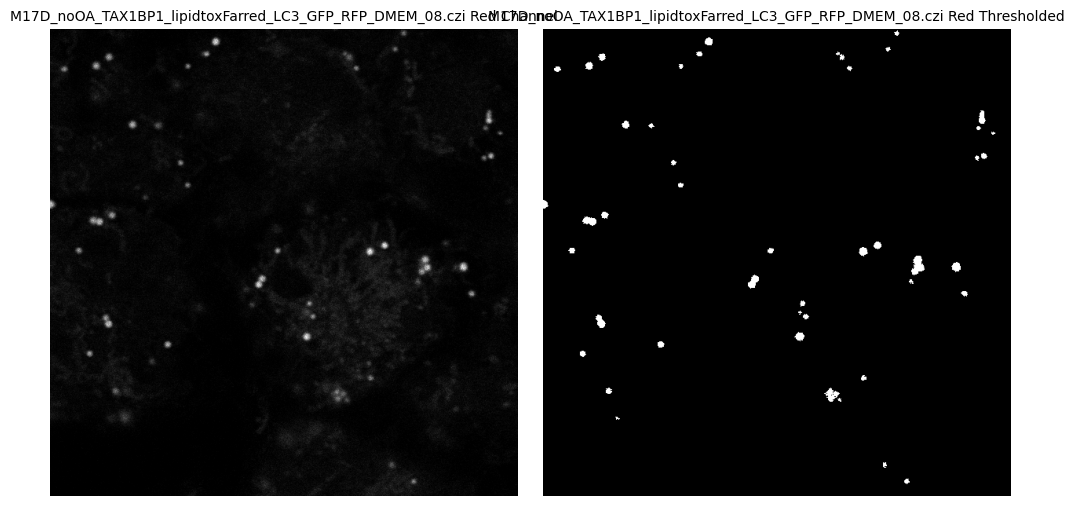

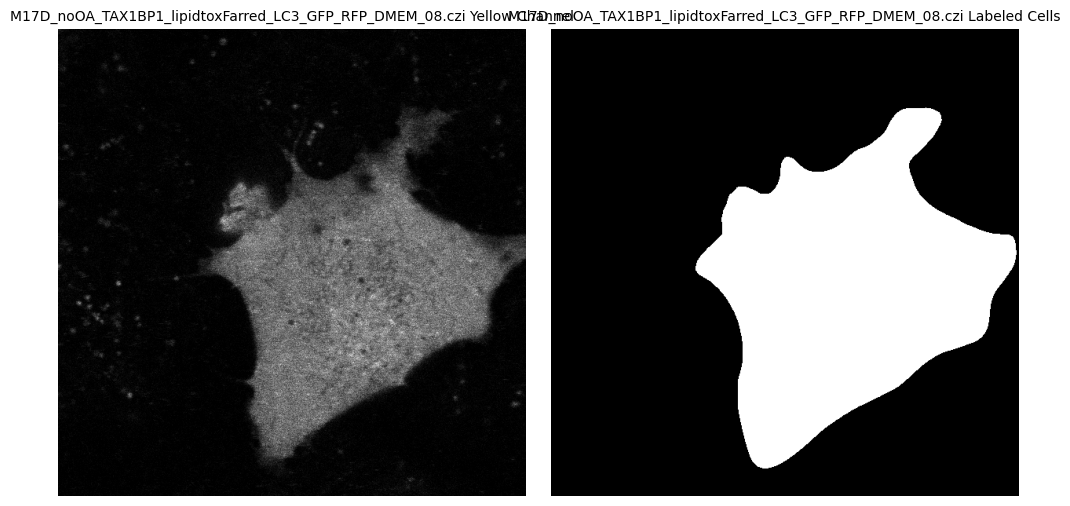

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


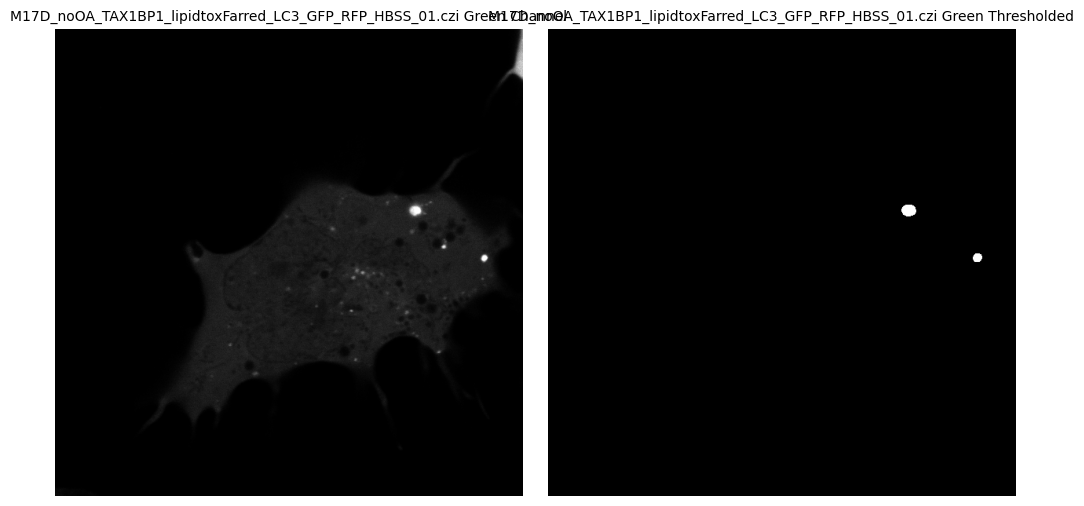

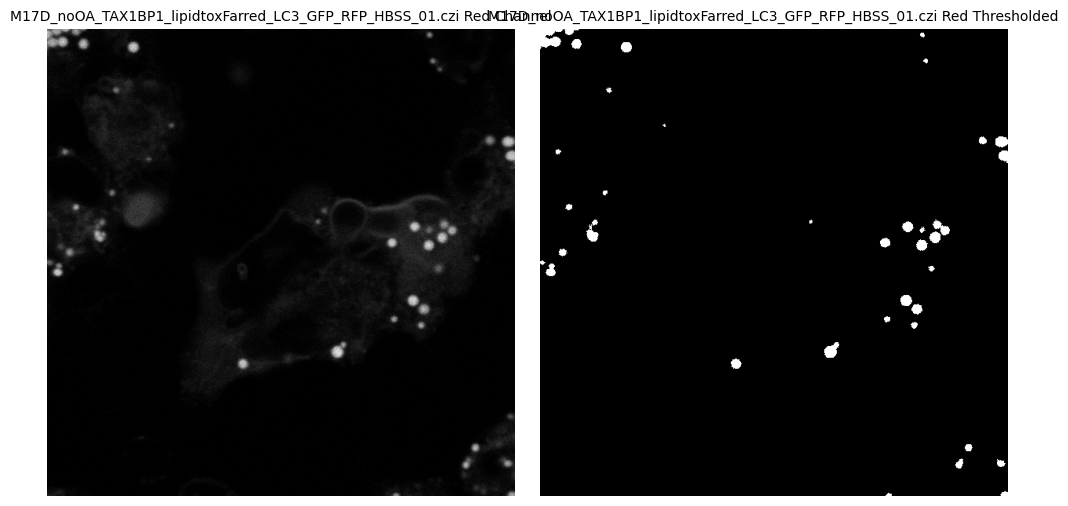

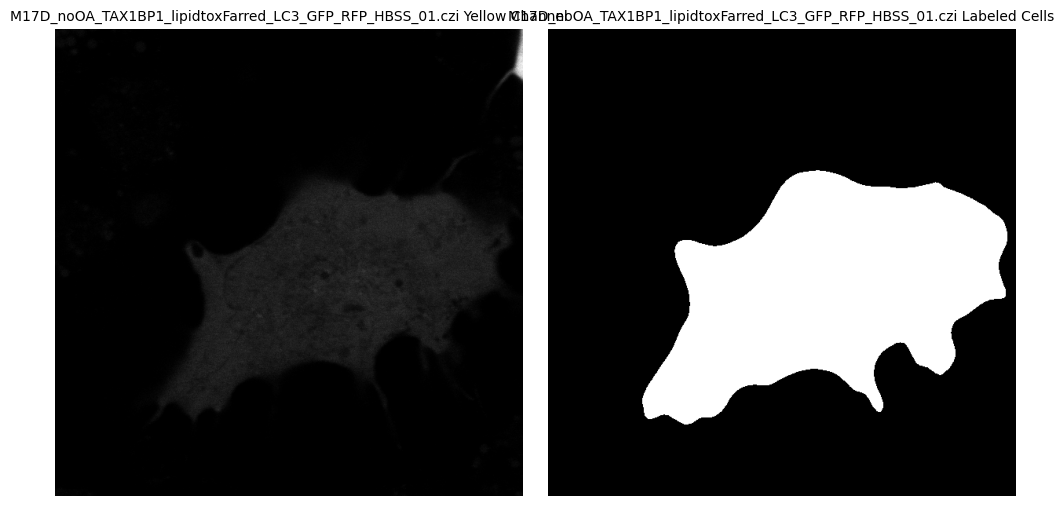

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


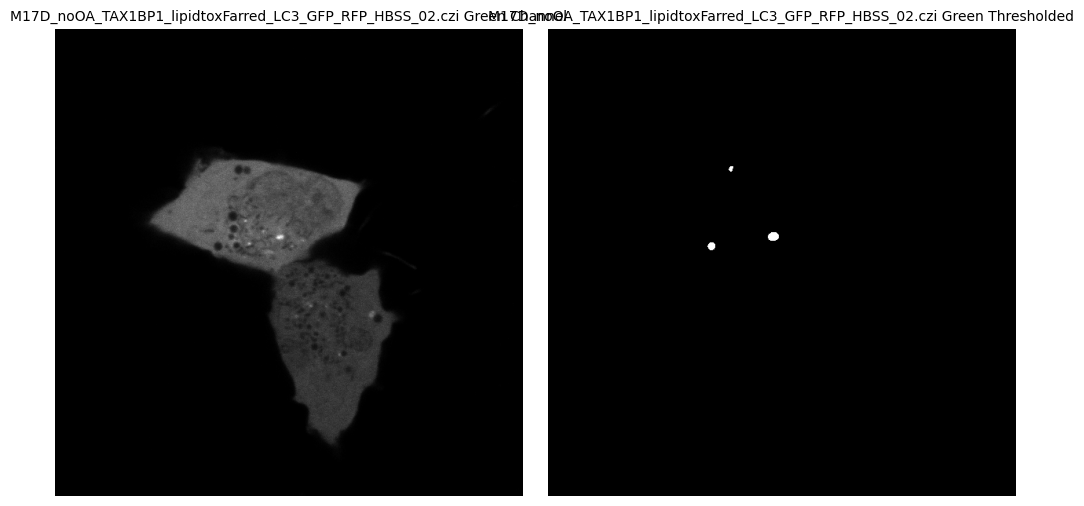

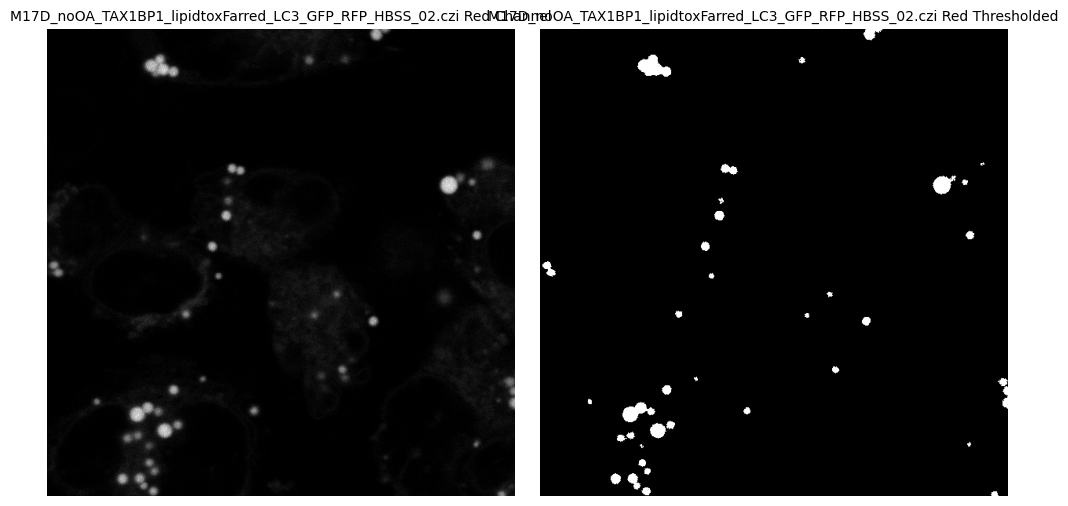

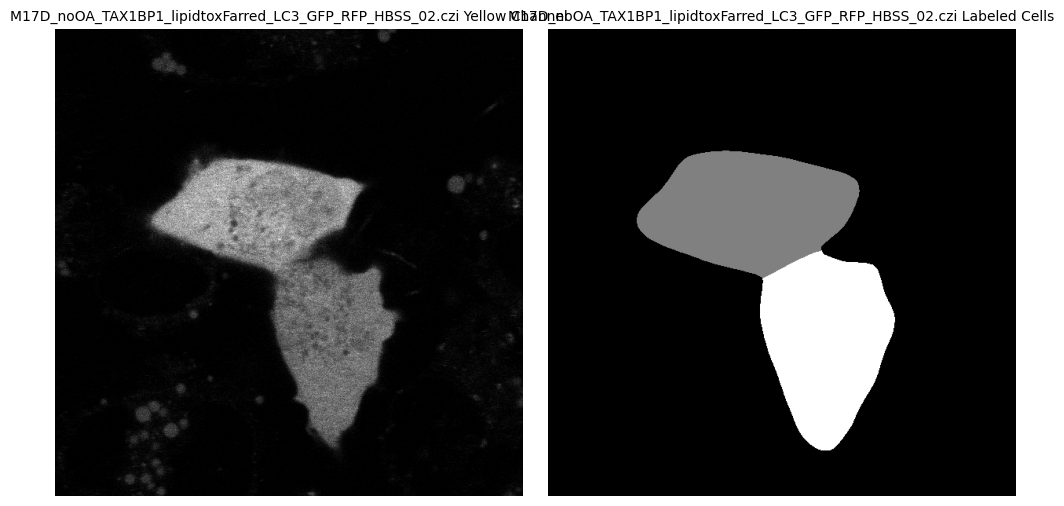

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


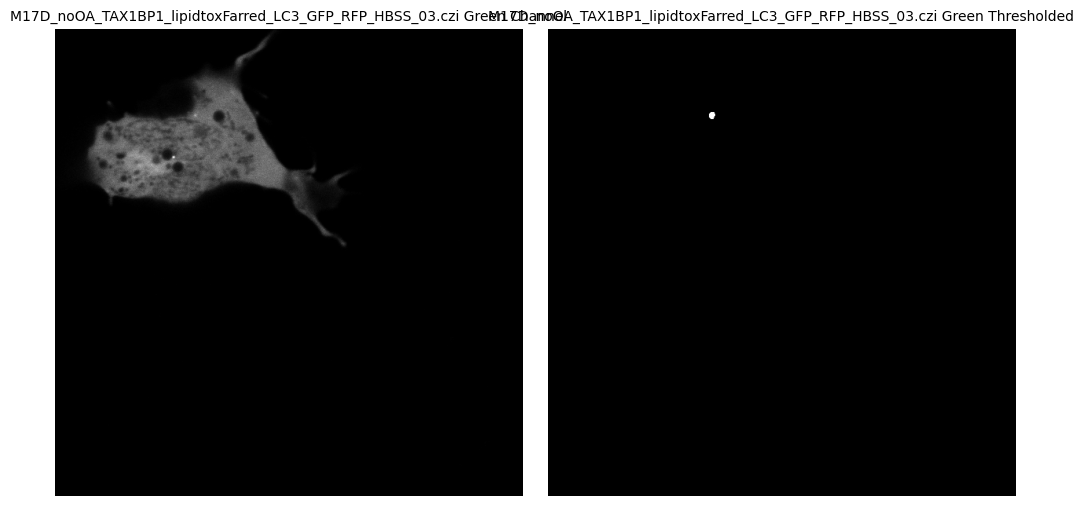

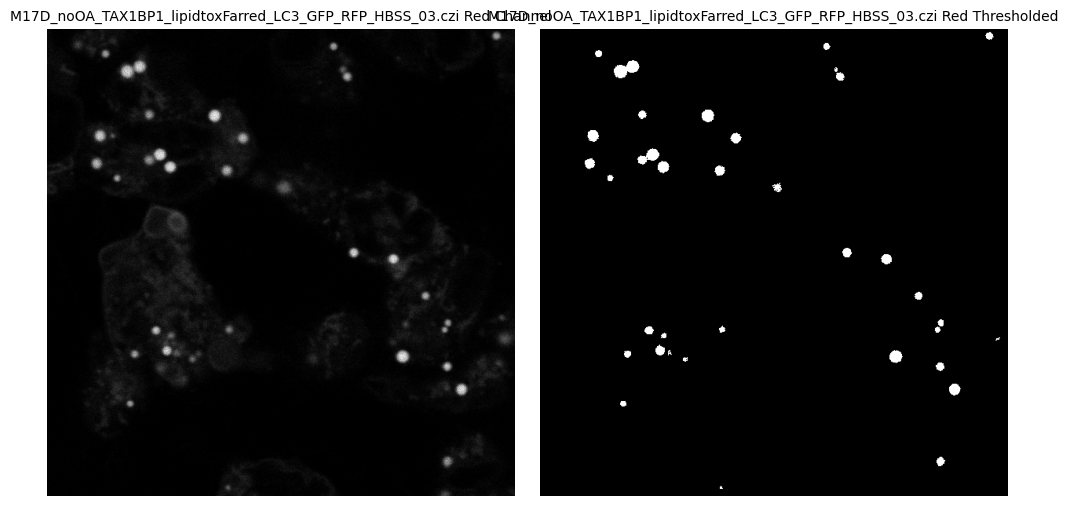

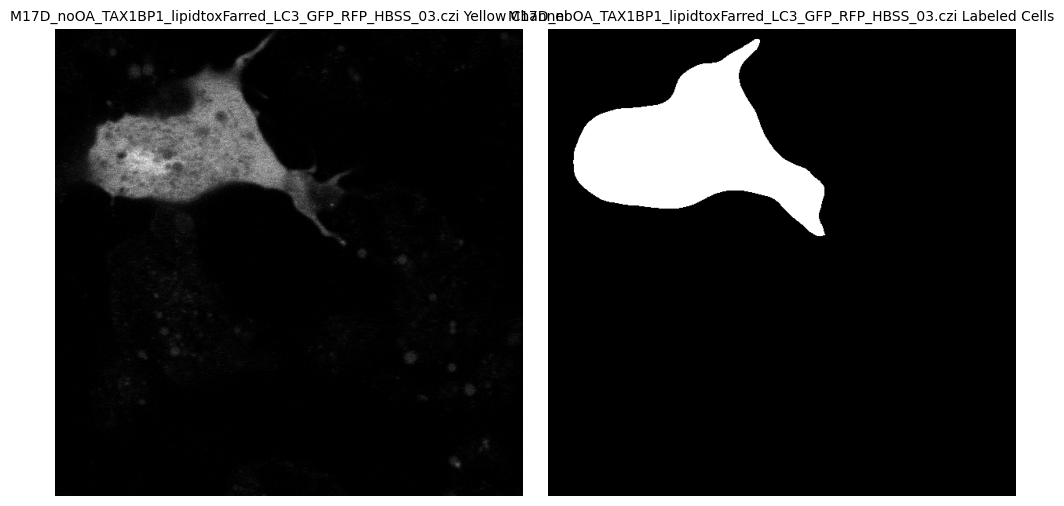

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


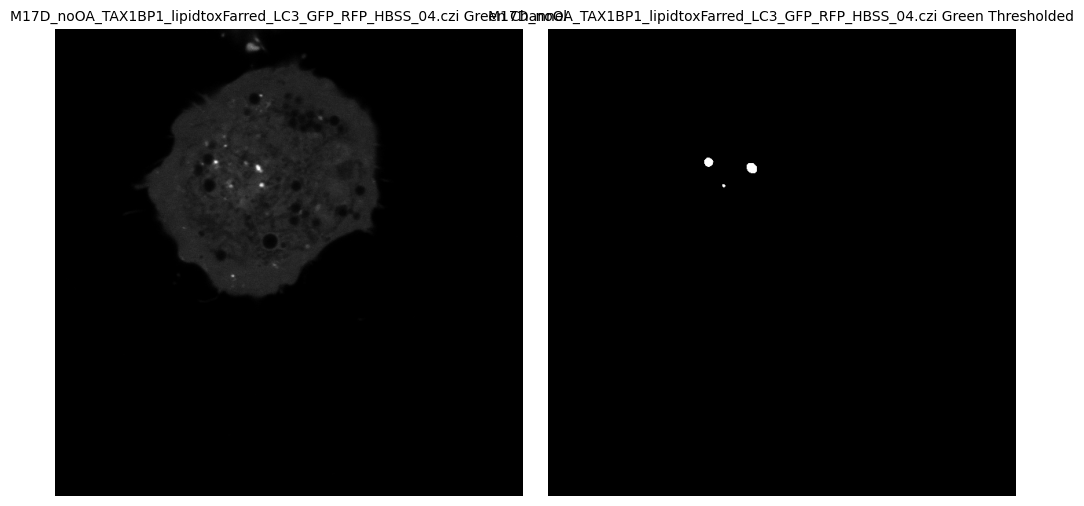

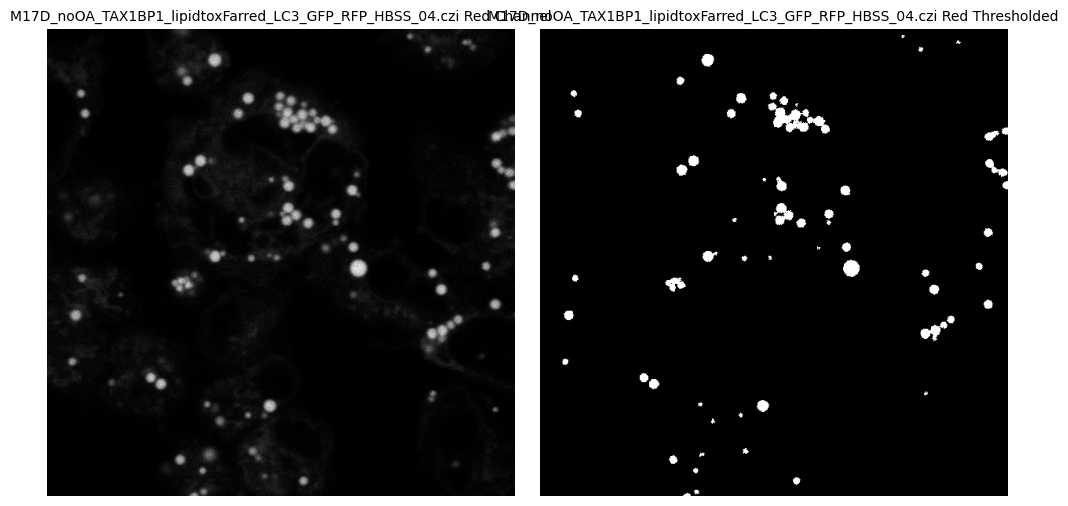

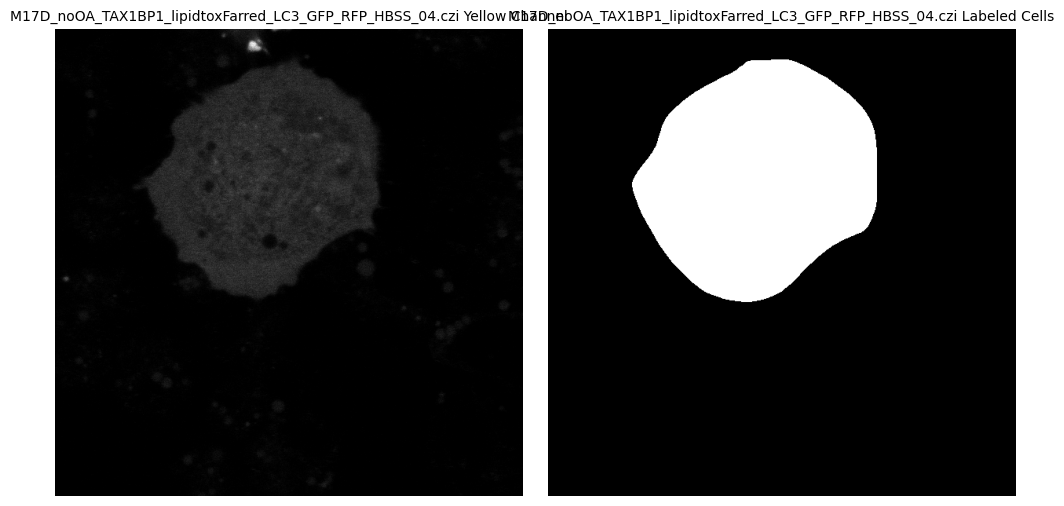

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


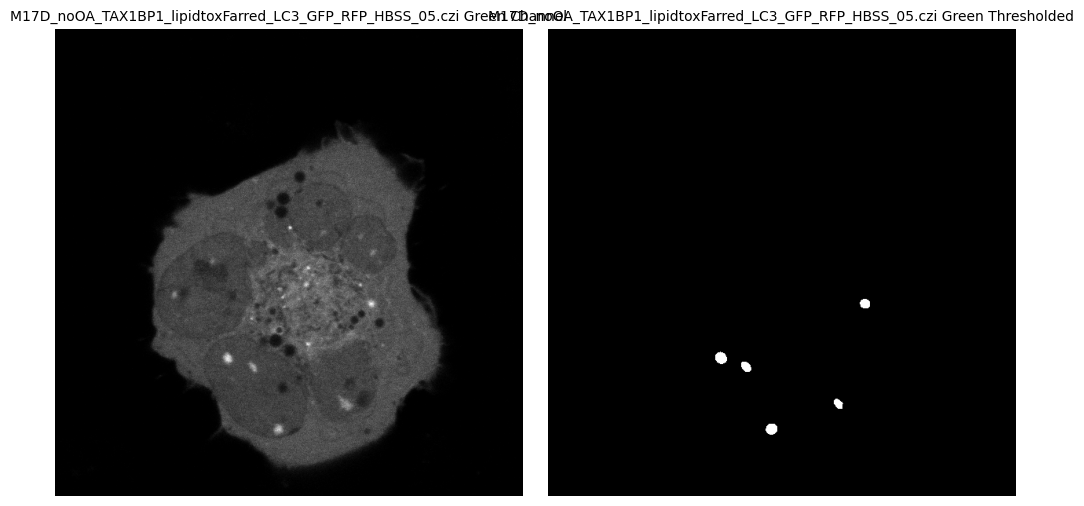

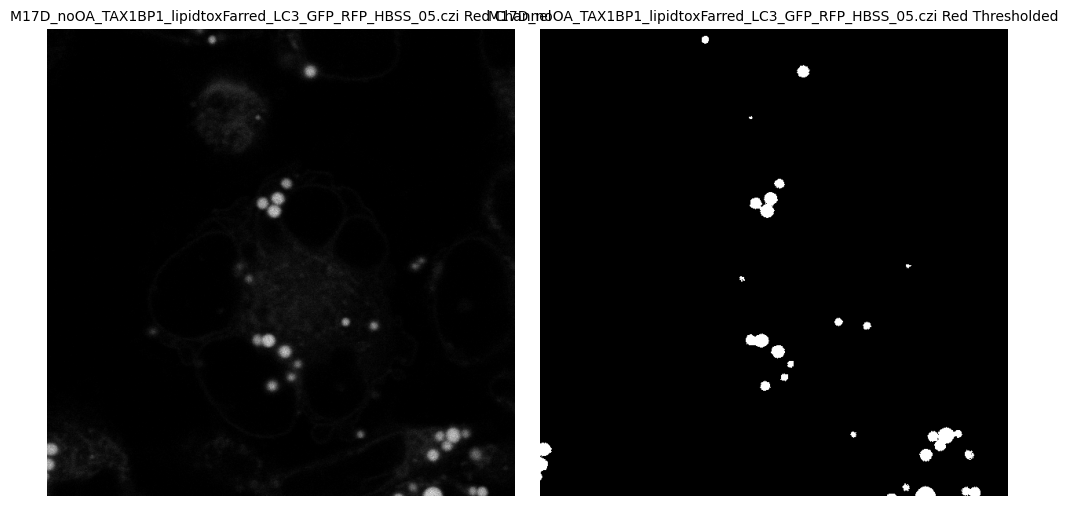

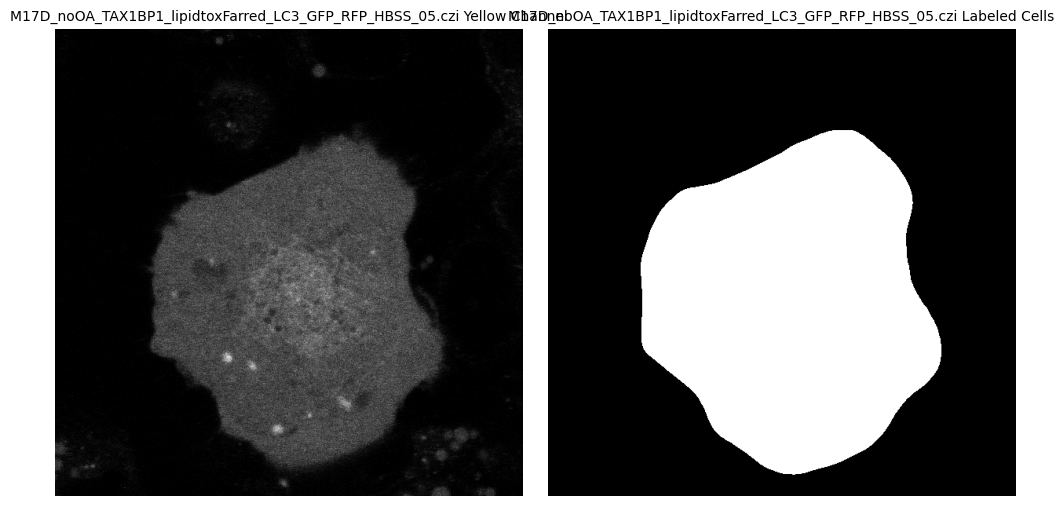

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


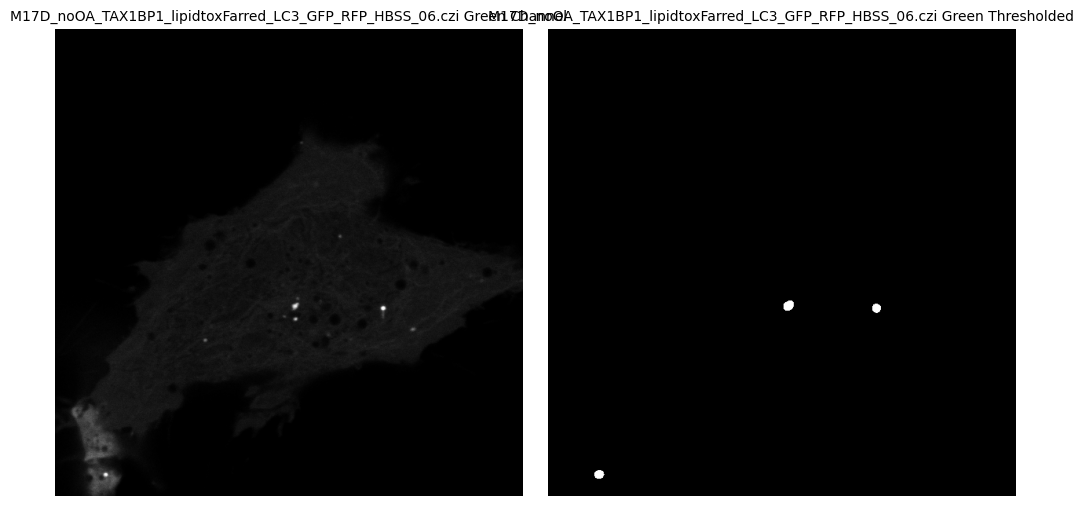

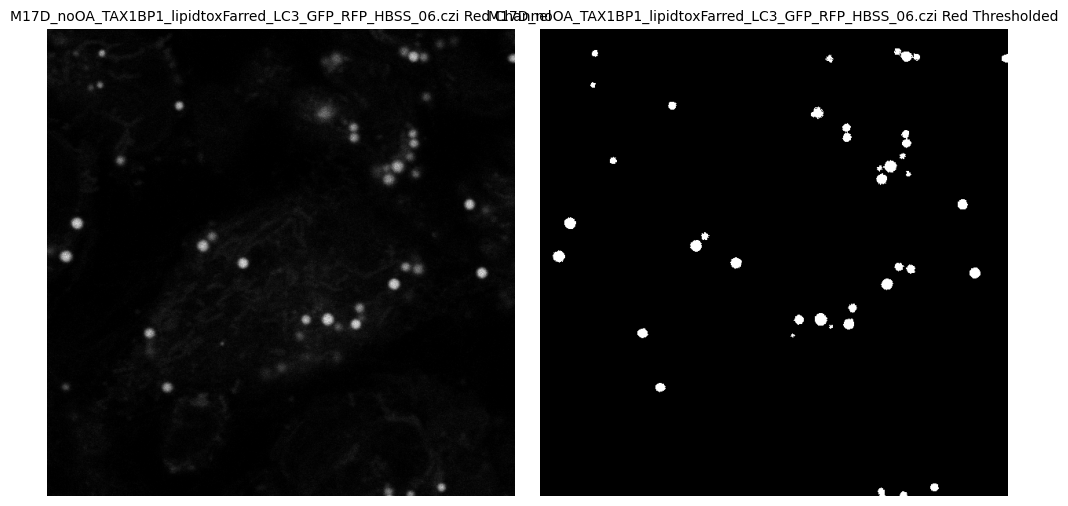

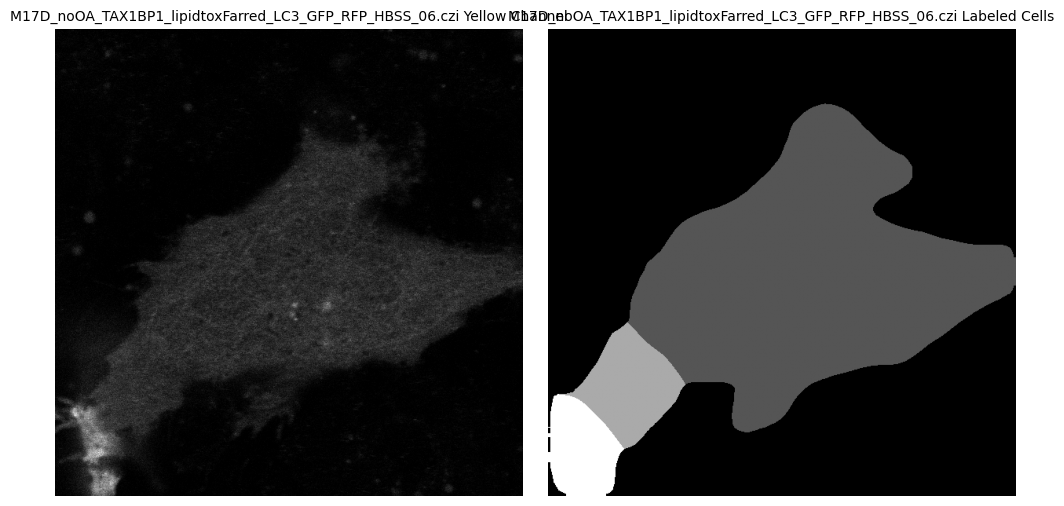

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


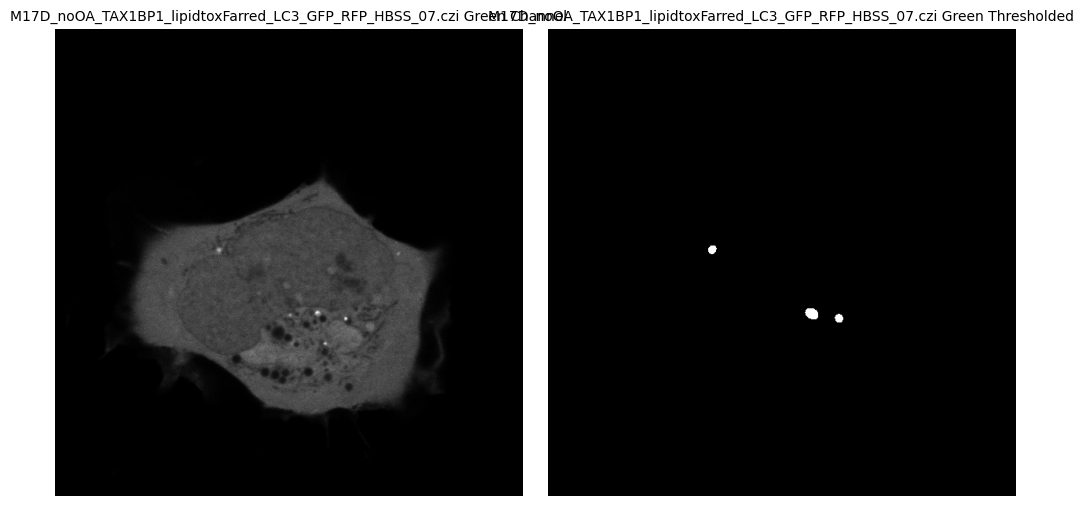

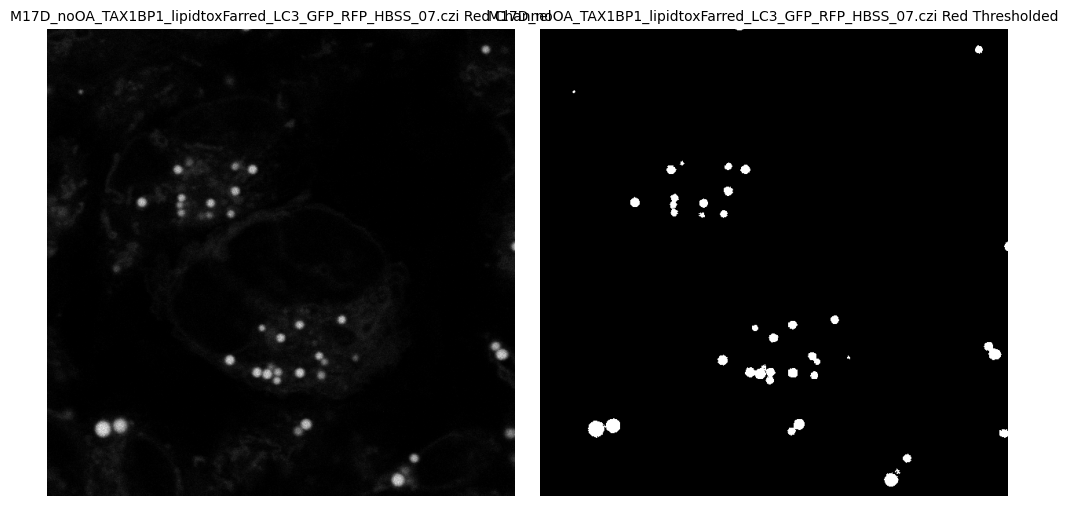

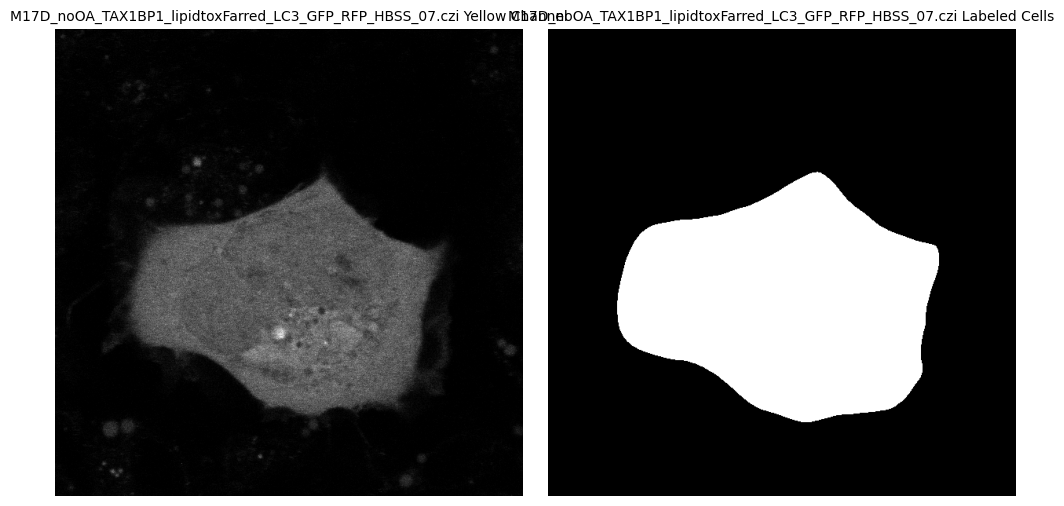

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


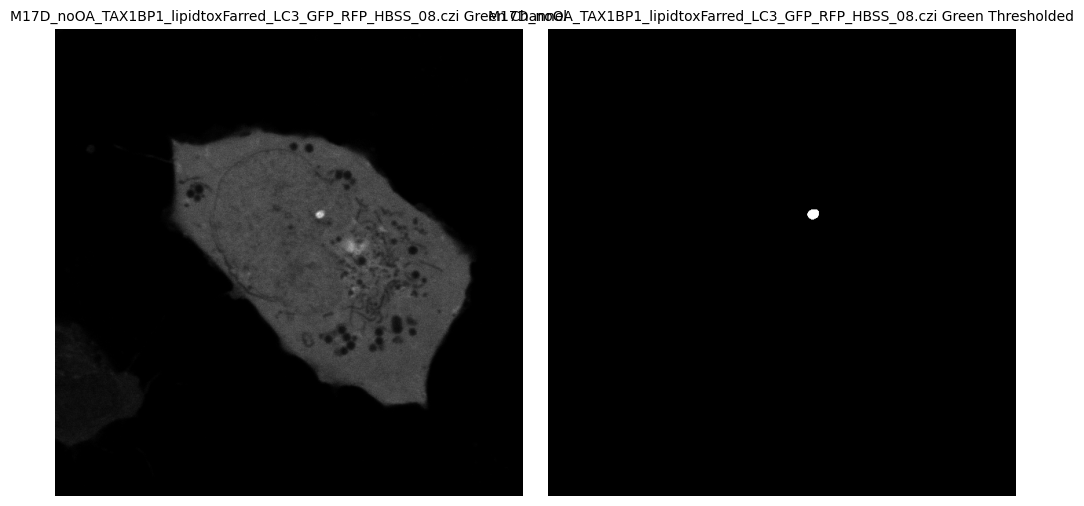

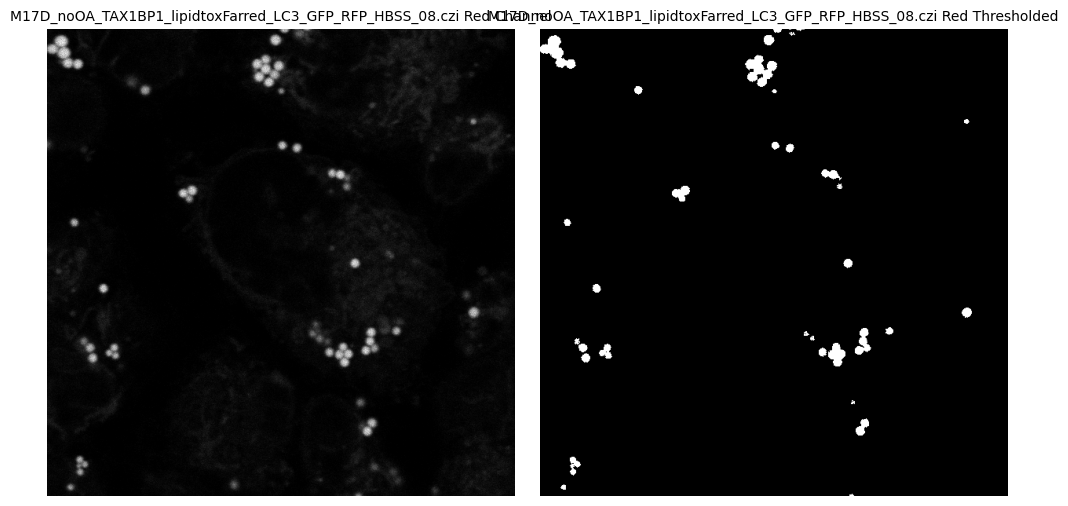

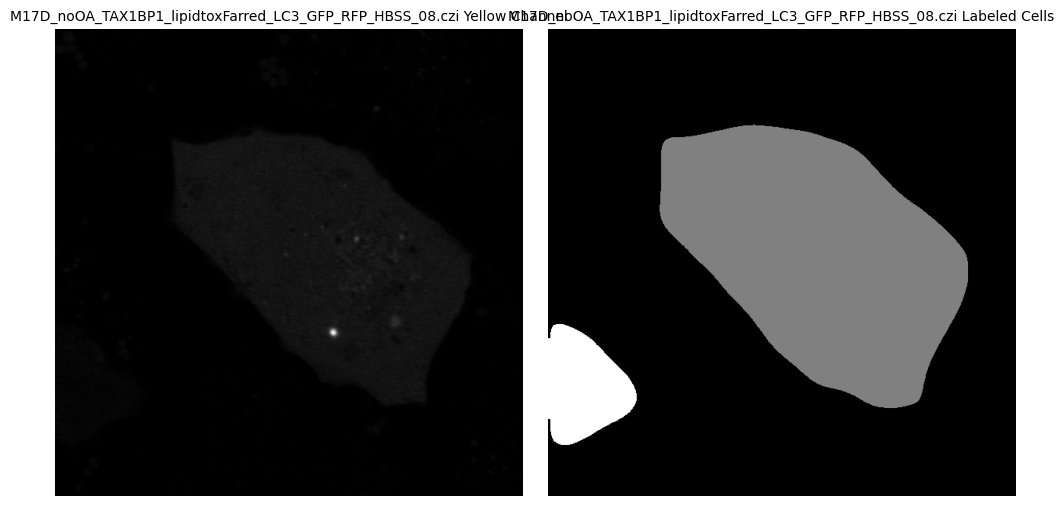

In [15]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()
    df_cell_summary_list = []
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=MODEL_TYPE,
        checkpoint=CHECKPOINT,
        device=DEVICE,
        is_tiled=False,
    )


    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
    
        red, yellow, green= extract_channels(image_squeezed)

        df_cell_summary = analysis(green, red, yellow, path, predictor, segmenter)


        df_cell_summary_list.append(df_cell_summary)

    combined_cell_summary_df = pd.concat(df_cell_summary_list, ignore_index=True)
    output_summary_path = os.path.join(output_dir, '92425_LIPOPHAGY_TAX1BP1_SUMMARY.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)
    
if __name__ == "__main__":
    image_folder = '92425_images_TAX1BP1'
    main(image_folder)